In [3]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Import Libraries

In [4]:
import numpy as np
import pandas as pd

#import matplotlib.pyplot as plt
#%matplotlib inline

from os import scandir, makedirs, path
import xml.etree.ElementTree as ET 

from PIL import Image
import json 
import io
import pickle

### Path Location

In [5]:
PATH=f'exp/pascal-voc'

# Exctact Zip File of Pascal 2012 VOC Data

In [6]:
# # Extract Files from zip
# # Link in Homework did not work, instead downloaded from https://course.fast.ai/datasets 
# import tarfile
# tarfile.open(f'{PATH}.tgz', 'r:gz').extractall('exp')

# Functions

In [8]:
def read_content(xml_file):
    '''Parse the xml file to get the objects names in list and bounding boxes in list    
    '''
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    list_with_all_names = []
    
    for boxes in root.iter('object'):
        
        for nm in boxes.findall("name"): list_with_all_names.append(nm.text)     
        
        ymin, xmin, ymax, xmax = None, None, None, None
        for box in boxes.findall("bndbox"):
            ymin = int(float(box.find("ymin").text))
            xmin = int(float(box.find("xmin").text))
            ymax = int(float(box.find("ymax").text))
            xmax = int(float(box.find("xmax").text))

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return list_with_all_names, list_with_all_boxes

In [83]:
def SaveImageNewFolder(idx):
    # Use PIL to open Image
    img = Image.open(data.loc[idx,'ImagePath'])
    # Get bounding box location
    ymin=data.loc[idx,'ymin']
    xmin=data.loc[idx,'xmin'] 
    ymax=data.loc[idx,'ymax'] 
    xmax=data.loc[idx,'xmax'] 
    bbox=[ymin, xmin, ymax, xmax]
    # Get image Classification
    objClass=data.loc[idx,'Class']
    # new name to save image as index added sonot to repeat file names
    save_name=f"{data.loc[idx,'File']}_{idx}.jpg"
    # crop and resize image
    img_crop_resize=img.crop(tuple(bbox)).resize((224,224))

    #Makes image folder
    fldr=f'{PATH}/224x224 Images/{objClass}'
    makedirs(fldr, exist_ok=True)
    # Save image
    img_crop_resize.save(f'{fldr}/{save_name}')

In [165]:
def img_pil_to_data(img_pil):
    '''Save Image in as byte array'''
    f = io.BytesIO()
    img_pil.save(f, format="JPEG")
    img_data = f.getvalue()
    return img_data

In [166]:
def CropAndResizeImage(idx):
    # Use PIL to open Image
    img = Image.open(data.loc[idx,'ImagePath'])
    # Get bounding box location
    ymin=data.loc[idx,'ymin']
    xmin=data.loc[idx,'xmin'] 
    ymax=data.loc[idx,'ymax'] 
    xmax=data.loc[idx,'xmax'] 
    bbox=[ymin, xmin, ymax, xmax] 
    # Get image Classification
    objClass=data.loc[idx,'Class']
    
    # crop and resize image
    img_crop_resize=img.crop(tuple(bbox)).resize((224,224))
    
    return img_pil_to_data(img_crop_resize)

In [163]:
def img_data_to_pil(img_data):
    '''Byte array back to Image'''
    f = io.BytesIO()
    f.write(img_data)
    img_pil = Image.open(f)
    return img_pil


# Get Data

In [10]:
# paths of images and annotations
AnnoPath=f'{PATH}/VOC2012/Annotations'
ImgPath=f'{PATH}/VOC2012/JPEGImages'

In [11]:
# Get images in folder without .jpg in annotation and image folder
Ifiles=[o.name.split('.')[0] for o in scandir(f'{ImgPath}')]
Afiles=[o.name.split('.')[0] for o in scandir(f'{AnnoPath}')]

In [18]:

# inner join of files with images and files with xml

dfile=pd.DataFrame(Ifiles,columns=['Files']).merge(pd.DataFrame(Afiles,columns=['Files']))

files=dfile['Files'].to_numpy()

In [72]:
%%time
## Makes data frame that is appended to with filename location, class objects and bounding box lists

data=pd.DataFrame([],columns=['Class','ymin', 'xmin', 'ymax', 'xmax','File','ImagePath','AnnotationPath'])
for fl in files:
    AnnotationPath=f'{AnnoPath}/{fl}.xml'
    name, boxes = read_content(AnnotationPath)
    # Dataframe 
    frame=pd.DataFrame(name,columns=['Class'])
    boxes=np.array(boxes)
    frame['ymin']=boxes[:,0]
    frame['xmin']=boxes[:,1] 
    frame['ymax']=boxes[:,2] 
    frame['xmax']=boxes[:,3]
    # Added file and path info
    frame['File']=fl
    frame['ImagePath']=f'{ImgPath}/{fl}.jpg'
    frame['AnnotationPath']=AnnotationPath
    # Appends to initial dataframe
    data=data.append(frame)    
    
data.reset_index(drop=True, inplace=True)

Wall time: 4min 20s


In [73]:
data.head(20)

,Class,ymin,xmin,ymax,xmax,File,ImagePath,AnnotationPath
0,person,174,101,349,351,2007_000027,exp/pascal-voc/VOC2012/JPEGImages/2007_000027.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000027...
1,aeroplane,104,78,375,183,2007_000032,exp/pascal-voc/VOC2012/JPEGImages/2007_000032.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000032...
2,aeroplane,133,88,197,123,2007_000032,exp/pascal-voc/VOC2012/JPEGImages/2007_000032.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000032...
3,person,195,180,213,229,2007_000032,exp/pascal-voc/VOC2012/JPEGImages/2007_000032.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000032...
4,person,26,189,44,238,2007_000032,exp/pascal-voc/VOC2012/JPEGImages/2007_000032.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000032...
5,aeroplane,9,107,499,263,2007_000033,exp/pascal-voc/VOC2012/JPEGImages/2007_000033.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000033...
6,aeroplane,421,200,482,226,2007_000033,exp/pascal-voc/VOC2012/JPEGImages/2007_000033.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000033...
7,aeroplane,325,188,411,223,2007_000033,exp/pascal-voc/VOC2012/JPEGImages/2007_000033.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000033...
8,tvmonitor,156,89,344,279,2007_000039,exp/pascal-voc/VOC2012/JPEGImages/2007_000039.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000039...
9,train,263,32,500,295,2007_000042,exp/pascal-voc/VOC2012/JPEGImages/2007_000042.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000042...


In [74]:
data.sample(10)

,Class,ymin,xmin,ymax,xmax,File,ImagePath,AnnotationPath
11093,bottle,446,1,477,80,2008_006111,exp/pascal-voc/VOC2012/JPEGImages/2008_006111.jpg,exp/pascal-voc/VOC2012/Annotations/2008_006111...
44214,person,71,196,129,375,2012_001905,exp/pascal-voc/VOC2012/JPEGImages/2012_001905.jpg,exp/pascal-voc/VOC2012/Annotations/2012_001905...
47143,person,68,174,150,251,2012_004078,exp/pascal-voc/VOC2012/JPEGImages/2012_004078.jpg,exp/pascal-voc/VOC2012/Annotations/2012_004078...
11533,car,1,228,95,343,2008_006392,exp/pascal-voc/VOC2012/JPEGImages/2008_006392.jpg,exp/pascal-voc/VOC2012/Annotations/2008_006392...
10190,cat,1,39,321,500,2008_005469,exp/pascal-voc/VOC2012/JPEGImages/2008_005469.jpg,exp/pascal-voc/VOC2012/Annotations/2008_005469...
42980,person,98,168,129,248,2012_001043,exp/pascal-voc/VOC2012/JPEGImages/2012_001043.jpg,exp/pascal-voc/VOC2012/Annotations/2012_001043...
15155,aeroplane,59,95,491,216,2009_000032,exp/pascal-voc/VOC2012/JPEGImages/2009_000032.jpg,exp/pascal-voc/VOC2012/Annotations/2009_000032...
6806,person,129,196,270,485,2008_003220,exp/pascal-voc/VOC2012/JPEGImages/2008_003220.jpg,exp/pascal-voc/VOC2012/Annotations/2008_003220...
2862,car,285,260,305,277,2008_000659,exp/pascal-voc/VOC2012/JPEGImages/2008_000659.jpg,exp/pascal-voc/VOC2012/Annotations/2008_000659...
28591,person,329,63,401,166,2010_005410,exp/pascal-voc/VOC2012/JPEGImages/2010_005410.jpg,exp/pascal-voc/VOC2012/Annotations/2010_005410...


In [76]:
fn='exp/RBE595_HW3_Pascal_2012_VOC'
# Save dataframe how it is saved in memory
#data.to_feather(fn)

# load dataframe from feather
#data=pd.read_feather(fn)

,Class,ymin,xmin,ymax,xmax,File,ImagePath,AnnotationPath
0,person,174,101,349,351,2007_000027,exp/pascal-voc/VOC2012/JPEGImages/2007_000027.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000027...
1,aeroplane,104,78,375,183,2007_000032,exp/pascal-voc/VOC2012/JPEGImages/2007_000032.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000032...
2,aeroplane,133,88,197,123,2007_000032,exp/pascal-voc/VOC2012/JPEGImages/2007_000032.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000032...
3,person,195,180,213,229,2007_000032,exp/pascal-voc/VOC2012/JPEGImages/2007_000032.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000032...
4,person,26,189,44,238,2007_000032,exp/pascal-voc/VOC2012/JPEGImages/2007_000032.jpg,exp/pascal-voc/VOC2012/Annotations/2007_000032...
...,...,...,...,...,...,...,...,...
47463,person,59,220,166,415,2012_004328,exp/pascal-voc/VOC2012/JPEGImages/2012_004328.jpg,exp/pascal-voc/VOC2012/Annotations/2012_004328...
47464,person,219,226,268,332,2012_004328,exp/pascal-voc/VOC2012/JPEGImages/2012_004328.jpg,exp/pascal-voc/VOC2012/Annotations/2012_004328...
47465,person,57,88,284,397,2012_004329,exp/pascal-voc/VOC2012/JPEGImages/2012_004329.jpg,exp/pascal-voc/VOC2012/Annotations/2012_004329...
47466,person,230,133,370,441,2012_004330,exp/pascal-voc/VOC2012/JPEGImages/2012_004330.jpg,exp/pascal-voc/VOC2012/Annotations/2012_004330...


In [77]:
data['Class'].unique()

array(['person', 'aeroplane', 'tvmonitor', 'train', 'boat', 'dog',
       'chair', 'bird', 'bicycle', 'bottle', 'sheep', 'diningtable',
       'horse', 'motorbike', 'sofa', 'cow', 'car', 'cat', 'bus',
       'pottedplant'], dtype=object)

# Save Images to Folder

In [78]:
# Use PIL to open Image
idx=1
img = Image.open(data.loc[idx,'ImagePath'])
# Get bounding box location

ymin=data.loc[idx,'ymin']
xmin=data.loc[idx,'xmin'] 
ymax=data.loc[idx,'ymax'] 
xmax=data.loc[idx,'xmax'] 
bbox=[ymin, xmin, ymax, xmax]
# Get image Classification
objClass=data.loc[idx,'Class']
# new name to save image as index added sonot to repeat file names
save_name=f"{data.loc[idx,'File']}_{idx}.jpg"
# crop and resize image
img_crop=img.crop(tuple(bbox))
img_crop_resize=img_crop.resize((224,224))

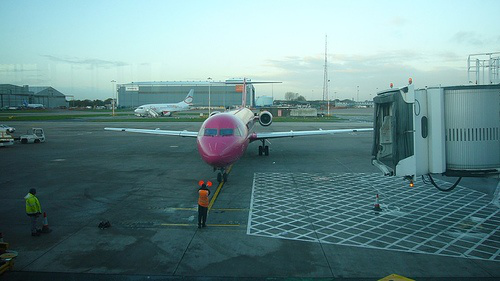

In [79]:
img

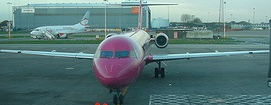

In [80]:
img_crop

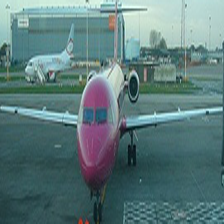

In [81]:
img_crop_resize

In [84]:
# %%time
# vecotized function over data index to speed up saving
# vSaveImageNewFolder=np.vectorize(SaveImageNewFolder)
# arr=vSaveImageNewFolder(data.index)
# Wall time: 13min 4s

Wall time: 13min 4s


In [85]:
%%time
for idx in data.index: SaveImageNewFolder(idx)
    

Wall time: 11min 58s


# Compress Files and Folders in Dataset

In [49]:
source_dir=f'{PATH}/224x224 Images'
output_filename='224x224Images.tar.gz'

In [22]:
source_dir, output_filename

('exp/pascal-voc/224x224 Images', '224x224Images.tar.gz')

In [23]:
with tarfile.open(f'exp/{output_filename}', "w:gz") as tar:
    tar.add(source_dir)
tar.close()

In [29]:
# Check to make sure it works
#tarfile.open(f'exp/{output_filename}', 'r:gz').extractall('temp')

# Pickle in Memory

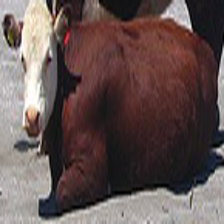

In [207]:
Class='cow'

idx = data[data['Class']==Class].index[0]; 

img = Image.open(data.loc[idx,'ImagePath'])
# Get bounding box location
ymin=data.loc[idx,'ymin']
xmin=data.loc[idx,'xmin'] 
ymax=data.loc[idx,'ymax'] 
xmax=data.loc[idx,'xmax'] 
bbox=[ymin, xmin, ymax, xmax]
# Get image Classification
objClass=data.loc[idx,'Class']
# new name to save image as index added sonot to repeat file names
save_name=f"{data.loc[idx,'File']}_{idx}.jpg"

img_crop_resize=img.crop(tuple(bbox)).resize((224,224))
img_crop_resize

In [208]:
file=img_pil_to_data(img_crop_resize)

That's a good lookin' heifer


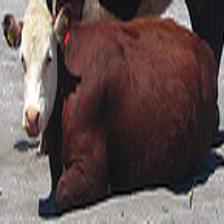

In [209]:
# Check to turn image back to PIL
print("That's a good lookin' heifer")
img_data_to_pil(file)


In [212]:

# Make dictionary with image classes as keys and values an empty dictionary to be appended to later
Class_list=np.sort(data['Class'].dropna().unique())
Class_dict={}
for c in Class_list: Class_dict.update({c:[]})

In [213]:
%%time
# Add byte Array to dictionary
for Class in Class_list:
    ClssIndx=data[data['Class']==Class].index

    for idx in ClssIndx:
        Class_dict.get(Class).append(CropAndResizeImage(idx))

Wall time: 7min 59s


In [214]:
pd_Class_dict=Class_dict

In [232]:
# makes lists same length to put in pandas dataframe
lmax=0
for key in pd_Class_dict.keys():
    if len(pd_Class_dict.get(key))>lmax:
        lmax=len(pd_Class_dict.get(key))
        #print(key,len(pd_Class_dict.get(key)))
        

for key in pd_Class_dict.keys(): pd_Class_dict.update({key: pd_Class_dict.get(key)+[np.nan]*(lmax-len(pd_Class_dict.get(key))) })

In [233]:
lmax

24727

In [236]:
pd.DataFrame(pd_Class_dict).head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xff

In [235]:
pd.DataFrame(pd_Class_dict).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24727 entries, 0 to 24726
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   aeroplane    1002 non-null   object
 1   bicycle      837 non-null    object
 2   bird         1271 non-null   object
 3   boat         1059 non-null   object
 4   bottle       1561 non-null   object
 5   bus          685 non-null    object
 6   car          2492 non-null   object
 7   cat          1277 non-null   object
 8   chair        3058 non-null   object
 9   cow          771 non-null    object
 10  diningtable  802 non-null    object
 11  dog          1598 non-null   object
 12  horse        803 non-null    object
 13  motorbike    801 non-null    object
 14  person       24727 non-null  object
 15  pottedplant  1202 non-null   object
 16  sheep        1084 non-null   object
 17  sofa         841 non-null    object
 18  train        704 non-null    object
 19  tvmonitor    893 non-null

In [238]:
with open('224x224Images.pkl', 'wb') as handle:
    pickle.dump(Class_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)



#### Reload File to make sure it all works

In [239]:
with open('224x224Images.pkl', 'rb') as handle:
    load_check = pickle.load(handle)

In [242]:
file=load_check.get('cow')[0]

How you Mooin'


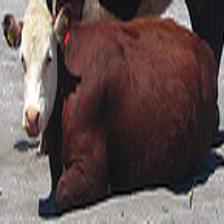

In [246]:
print("How you Mooin'")
img_data_to_pil(file)

# Fin

In [247]:
from datetime import datetime as dt
print(f'Finished at: {dt.now()}')

Finished at: 2020-10-16 16:36:03.902788
